# Import Libraries

In [25]:
import os
import re
import time
import pandas as pd
import numpy as np
import datetime as dt
import missingno as msno

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy import signal
import pmdarima as pm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandas.plotting import lag_plot
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

In [4]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return np.nan

In [5]:
def extract_topic(string):
    try:
        return re.match('(.*?)\_[a-z][a-z].wikipedia.org', string).group(1)
    except AttributeError:
        return np.nan

In [6]:
## page_details = train1_df['Page'].str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

def extract_pages(df, col):
    try:
        df['Extracted_Pages'] = df[col].apply(lambda x: x.split('_2017')[0])
    except:
        print('It is training data...')

    df['Topic'] = df[col].apply(lambda x: extract_topic(x))
    df['Language'] = df[col].map(get_language)
    
    regex = re.compile('\w+.org')
    df['Website'] = df[col].apply(lambda x: regex.search(x)[0])
    df['Agent'] = df['Page'].str.extract(r'.wikipedia.org\_(.*)')

    try:
        df['Date'] = df[col].apply(lambda x: x.split('_')[4])
    except:
        print('There are no date info in Pages...')
    
    return df

In [7]:
def extract_agent(string):
    if ('all-access_spider' in string):
        return 'spider'
    elif ('desktop_all-agents' in string):
        return 'desktop'
    elif ('mobile-web_all-agents' in string):
        return 'mobile_web'
    elif ('all-access_all-agents' in string):
        return 'all_access'
    else:
        return string

# Data Wrangling

In [8]:
%time
train1_df = pd.read_csv(r'D:\03-Training\03-SelfLearning\02-KEILS\KEILS\data\train_1.csv')
train2_df = pd.read_csv(r'D:\03-Training\03-SelfLearning\02-KEILS\KEILS\data\train_2.csv')

key1_df = pd.read_csv(r'D:\03-Training\03-SelfLearning\02-KEILS\KEILS\data\key_1.csv')
key2_df = pd.read_csv(r'D:\03-Training\03-SelfLearning\02-KEILS\KEILS\data\key_2.csv')

ss1_df = pd.read_csv(r'D:\03-Training\03-SelfLearning\02-KEILS\KEILS\data\sample_submission_1.csv')
ss2_df = pd.read_csv(r'D:\03-Training\03-SelfLearning\02-KEILS\KEILS\data\sample_submission_2.csv')

Wall time: 0 ns


In [9]:
%time
train1_df = extract_pages(train1_df, 'Page')
train2_df = extract_pages(train2_df, 'Page')

key1_df = extract_pages(key1_df, 'Page')
key2_df = extract_pages(key2_df, 'Page')

## Removing the new features created in dataframe
model1_df = train1_df.iloc[:, :-5]

Wall time: 0 ns
There are no date info in Pages...
There are no date info in Pages...


In [10]:
## Evaluate the usage of months of each website
train1_mth_df = train1_df.iloc[:, :-5]

train1_mth_df_T = train1_mth_df.T
train1_mth_df_T.columns = train1_mth_df_T[:1].values.ravel()

train1_mth_df_T = train1_mth_df_T.iloc[1:]
train1_mth_df_T['Month'] = pd.DatetimeIndex(train1_mth_df_T.index).month

## Focusing the webs with language on 'en'

In [11]:
train1_df_en = train1_df.loc[train1_df['Language']=='en']
train1_df_en_topic = train1_df_en[train1_df_en.columns.difference(['Page', 'Extracted_Pages', 'Website', 'Language'])]
train1_df_en_topic['Agent'] = train1_df_en_topic['Agent'].apply(lambda x: extract_agent(x))

train1_df_en_topic_melt = train1_df_en_topic.T
train1_df_en_topic_melt.columns = pd.MultiIndex.from_arrays(train1_df_en_topic_melt.iloc[-2:,:].values)
train1_df_en_topic_melt.columns = ["_".join(pair) if pair[1]!='' else pair[0] for pair in train1_df_en_topic_melt.columns ]

train1_df_en_topic_melt = train1_df_en_topic_melt[:-2]

C:\Users\kew.jingsheng\AppData\Local\Continuum\anaconda3\envs\ts_forecasting\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Converting the dataframe to numeric for analysis and forecasting

In [12]:
train1_df_en_topic_melt.index = pd.to_datetime(train1_df_en_topic_melt.index)
desktop_train1_es_df = train1_df_en_topic_melt.filter(regex='desktop')
all_access_train1_es_df = train1_df_en_topic_melt.filter(regex='all_access')

for col in desktop_train1_es_df.columns:
    desktop_train1_es_df[col] = pd.to_numeric(desktop_train1_es_df[col], errors='coerce')
print(" done converting all columns in Desktop from string to numeric...")
    
for col in all_access_train1_es_df.columns:
    all_access_train1_es_df[col] = pd.to_numeric(all_access_train1_es_df[col], errors='coerce')
print(" done converting all columns in All_Access from string to numeric...")

C:\Users\kew.jingsheng\AppData\Local\Continuum\anaconda3\envs\ts_forecasting\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


 done converting all columns in Desktop from string to numeric...


C:\Users\kew.jingsheng\AppData\Local\Continuum\anaconda3\envs\ts_forecasting\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


 done converting all columns in All_Access from string to numeric...


## Select only one web for analysis and forecasting

In [13]:
sub_aa_train1_es_df = all_access_train1_es_df[['all_access_2012_Benghazi_attack']]

## Create time series features

In [26]:
decomposition = seasonal.seasonal_decompose(sub_aa_train1_es_df)
sub_aa_train1_es_df['Trend'] = decomposition.trend.ravel()
sub_aa_train1_es_df['Seasonal'] = decomposition.seasonal.ravel()
sub_aa_train1_es_df['Residual'] = decomposition.resid.ravel()

sub_aa_train1_es_df['Month'] = sub_aa_train1_es_df.index.month
sub_aa_train1_es_df['Year'] = sub_aa_train1_es_df.index.year

# EDA
1. Time Series data is a function of time, with some random error
    - $y_t = \alpha + y_{t-1} + \epsilon_t $

In [27]:
def horizontal_plot(df, col, title):
    count_df = pd.DataFrame(df[col].value_counts().reset_index())
    count_df.columns = [col, 'Count']

    fig, ax = plt.subplots(figsize=(6, 5))
    ax = sns.barplot(x='Count', y=col, data=count_df)

    ax.set_title('Counts of Agents across Website', fontsize=16, weight='bold')
    plt.ylabel(col, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+0.7),
                    xytext=(2, 10), textcoords='offset points')

    return plt

In [28]:
def multiple_time_series_plot(df, groupby_col, tile, xaxis, yaxis):
    temp_df = df.groupby([groupby_col]).sum().T
    temp_df.index.names = ['Date']

    fig, ax = plt.subplots(figsize=(20, 4))

    for col in temp_df.columns:
        _ = temp_df[col].plot(alpha=0.8, legend=True, linewidth=4)

    _ = plt.title(tile, fontsize=16, weight='bold')
    _ = plt.xlabel(xaxis, fontsize=14)
    _ = plt.ylabel(yaxis, fontsize=14)

    plt.show()

    return plt

In [29]:
def bar_plot(df, group_col, col, title):
    count_df= df.groupby([group_col]).count().reset_index()
    x = count_df[group_col]
    x_arrange = np.arange(len(x))

    fig, ax = plt.subplots(figsize=(6, 5))
    _ =plt.bar(x_arrange, col, data=count_df, color=(0.3,0.9,0.4,0.6))

    _ = plt.xticks(x_arrange, x)
    _ = plt.title(title, fontsize=16, weight='bold')
    _ = plt.ylabel(col,fontsize=14)
    _ = plt.xticks(fontsize=12)
    _ = plt.yticks(fontsize=12)
    
    return plt

In [30]:
def boxplot(df, groupby_var):
    temp_df = df.groupby([groupby_var]).sum().T
    temp_df.index.names = ['Date']
    temp_df_melt = pd.melt(temp_df)

    fig, ax = plt.subplots(figsize=(20, 5))
    box_plot = sns.boxplot(x='value', y=groupby_var, data=temp_df_melt)

    plt.title('Boxplot of {}'.format(groupby_var), size=16, weight='bold')
    plt.ylabel('{}'.format(groupby_var), size=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()

    return plt

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [32]:
def plotMovingAvg(series, col_name, window, plot_intervals=False, scale=1.96):
    """
        series: dataframe with timeseries
        window: rolling window size
        plot_intervals: show confidence intervals
    """

    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(20, 5))
    plt.title('Mobving Average of {}\n window size: {}'.format(col_name, window))
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

    return plt

In [33]:
missing_df = pd.DataFrame(train1_df.isnull().sum(), columns=['Missing_Value'])[1:]
missing_df

,Missing_Value
2015-07-01,20740
2015-07-02,20816
2015-07-03,20544
2015-07-04,20654
2015-07-05,20659
...,...
Extracted_Pages,0
Topic,17855
Language,17855
Website,0


In [34]:
agent_df = pd.DataFrame(train1_df['Agent'].value_counts())
agent_df

,Agent
all-access_all-agents,35099
mobile-web_all-agents,30923
all-access_spider,30614
desktop_all-agents,30572


<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

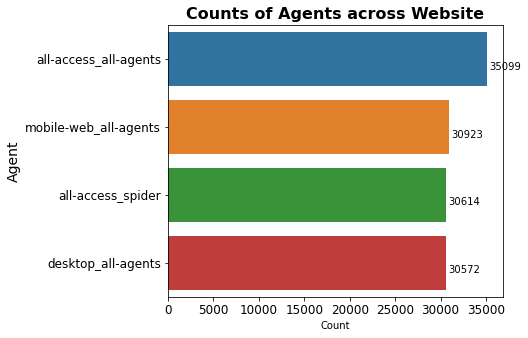

In [35]:
horizontal_plot(train1_df, 'Agent', 'Counts of Agents across Website')

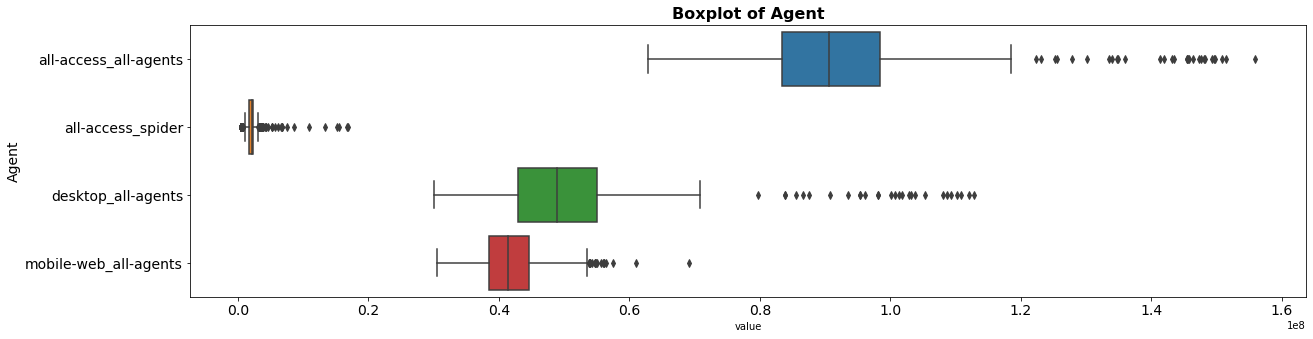

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [36]:
boxplot(train1_df, 'Agent')

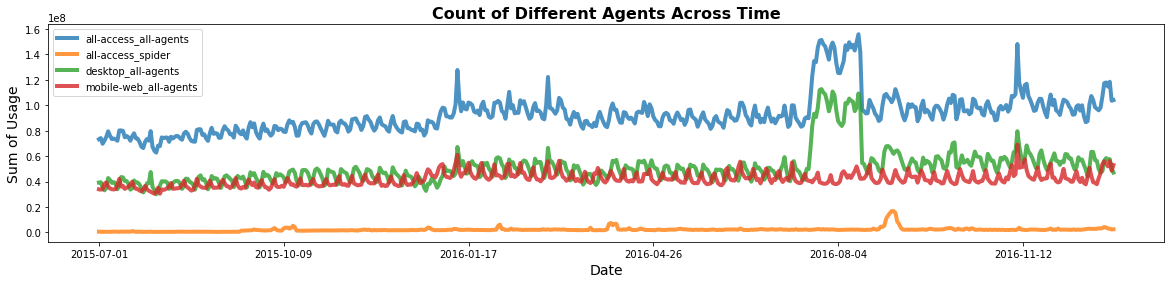

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
multiple_time_series_plot(train1_df, 'Agent', 'Count of Different Agents Across Time', 'Date', 'Sum of Usage')

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

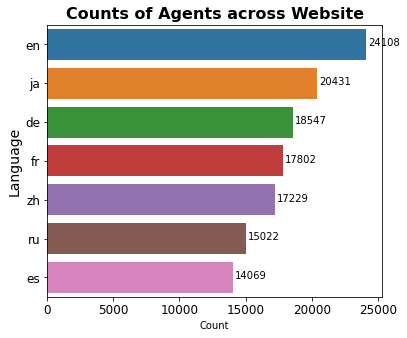

In [38]:
horizontal_plot(train1_df, 'Language', 'Counts of Languages Used Across Webs')

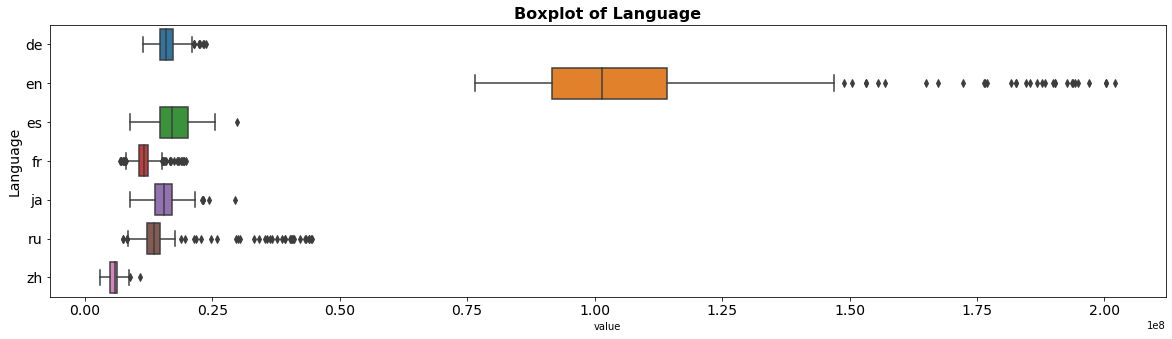

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [39]:
boxplot(train1_df, 'Language')

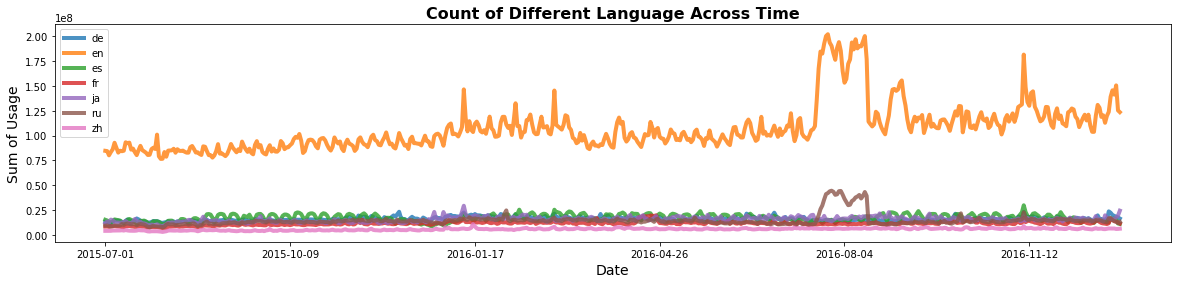

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [40]:
multiple_time_series_plot(train1_df, 'Language', 'Count of Different Language Across Time', 'Date', 'Sum of Usage')

In [41]:
## Access Agent and Language together on "en"

train1_df_en = train1_df.loc[train1_df['Language']=='en']
train1_df_en = train1_df_en[train1_df_en.columns.difference(['Page', 'Extracted_Pages', 'Topic', 'Website', 'Language'])]
train1_df_en_gp = train1_df_en.groupby(['Agent']).count().reset_index()

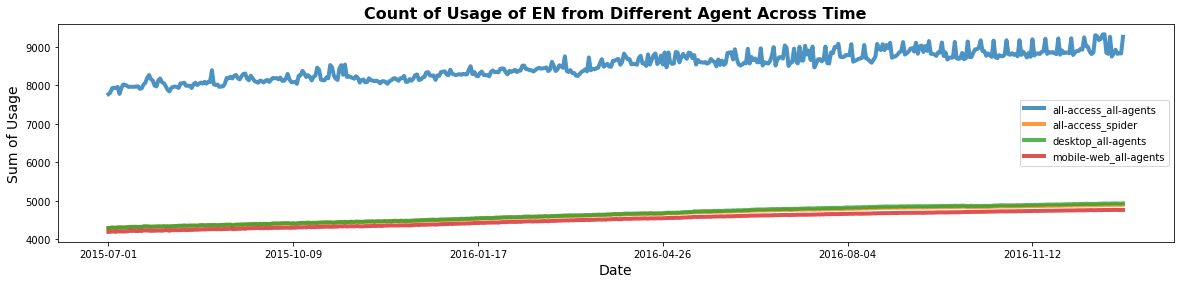

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [42]:
multiple_time_series_plot(train1_df_en_gp, 'Agent', 'Count of Usage of EN from Different Agent Across Time', 'Date', 'Sum of Usage')

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

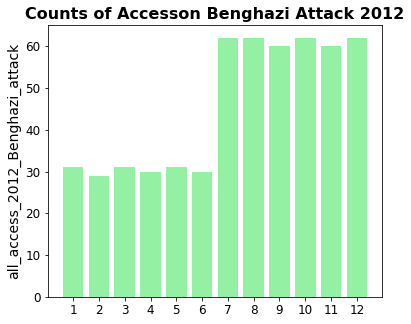

In [43]:
bar_plot(sub_aa_train1_es_df, 'Month', 'all_access_2012_Benghazi_attack', 'Counts of Accesson Benghazi Attack 2012')

## Moving Average

In [44]:
moving_avg_df = train1_df_en_gp.transpose()
moving_avg_df.columns = np.array(moving_avg_df[0:1]).flatten()
moving_avg_df = moving_avg_df[1:]
moving_avg_df.index = pd.to_datetime(moving_avg_df.index)

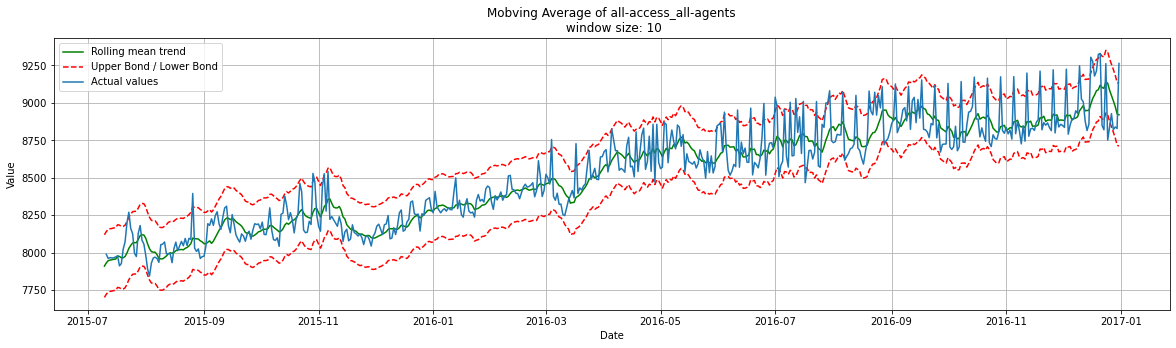

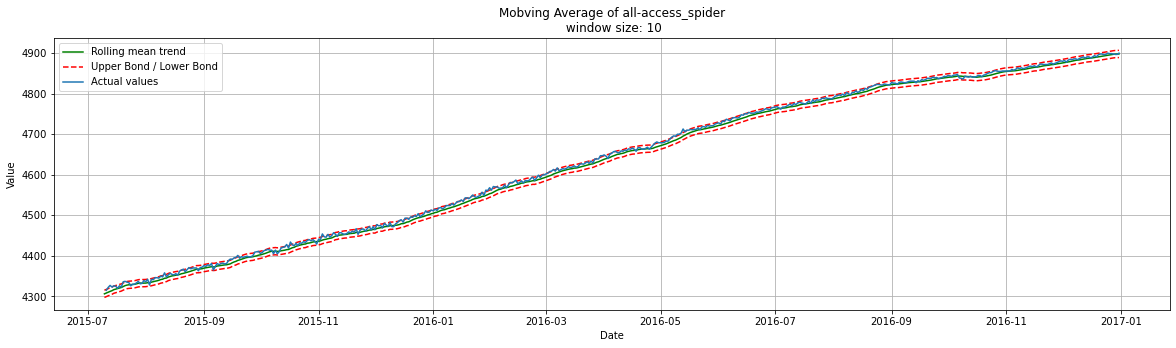

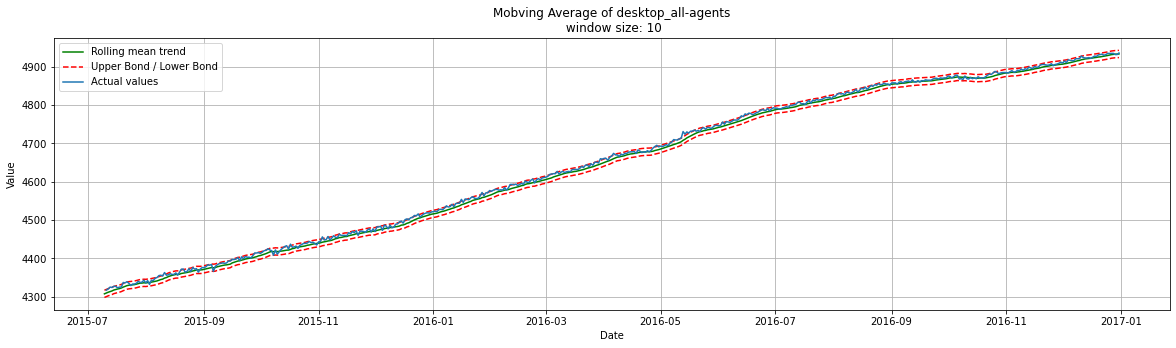

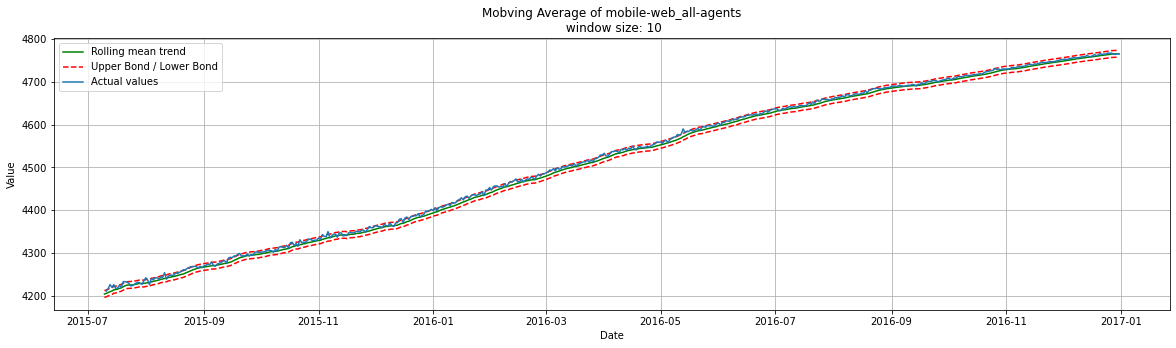

In [45]:
for col in moving_avg_df.columns:
    plotMovingAvg(moving_avg_df[col], col, 10, plot_intervals=True, scale=1)

## Decompose dataframe
1. Component:
    - Level
        - The average value in the series.
    - Trend
        - The increasing or decreasing value in the series.
    - Seasonality
        - The repeating short-term cycle in the series.
    - Noise
        - The random variation in the series.


<br> 2. Time series component can be divided into addictive or multiplicative:
   - Addictive:     **y(t) = Level + Trend + Seasonality + Noise**
   - Multiplicative: **y(t) = Level * Trend * Seasonality * Noise**

In [46]:
def seasonal_decompose(df, col):
    sub_df = df[[col]]
    decomposition = seasonal.seasonal_decompose(sub_df)

    trend = decomposition.trend
    cycle = decomposition.seasonal
    residual = decomposition.resid
    
    return trend, cycle, residual

In [47]:
def decompose_ts(df, col):
    sub_df = df[[col]]
    sub_df[col] = pd.to_numeric(sub_df[col], errors='coerce')
    sub_df = sub_df.reset_index().rename(columns={'index': 'Date'})
    sub_df['Date'] = pd.to_datetime(sub_df['Date'])
    sub_df = sub_df.set_index('Date')

    decomposition = sm.tsa.seasonal_decompose(sub_df, model='additive')

    rcParams['figure.figsize'] = (18, 8)
    decomposition.plot()

    plt.show()

    return plt

In [48]:
def component_plot(df, col):
    trend, cycle, residual = seasonal_decompose(df, col)

    fig, axarr = plt.subplots(4, sharex=True)

    df[col].plot(ax=axarr[0], color='b', linestyle='-')
    axarr[0].set_title('Daily Search from All Access')

    trend.plot(color='r', linestyle='-', ax=axarr[1])
    axarr[1].set_title('Trend Component')

    cycle.plot(color='g', linestyle='-', ax=axarr[2])
    axarr[2].set_title('Seasonal Component')

    residual.plot(color='k', linestyle='-', ax=axarr[3])
    axarr[3].set_title('Irregular Variations')
    
    return

In [49]:
def moving_avg(df, col, window_size):
    sub_df = df[[col]]
    sub_df[col] = sub_df[col].rolling(window_size).mean()
    
    return sub_df

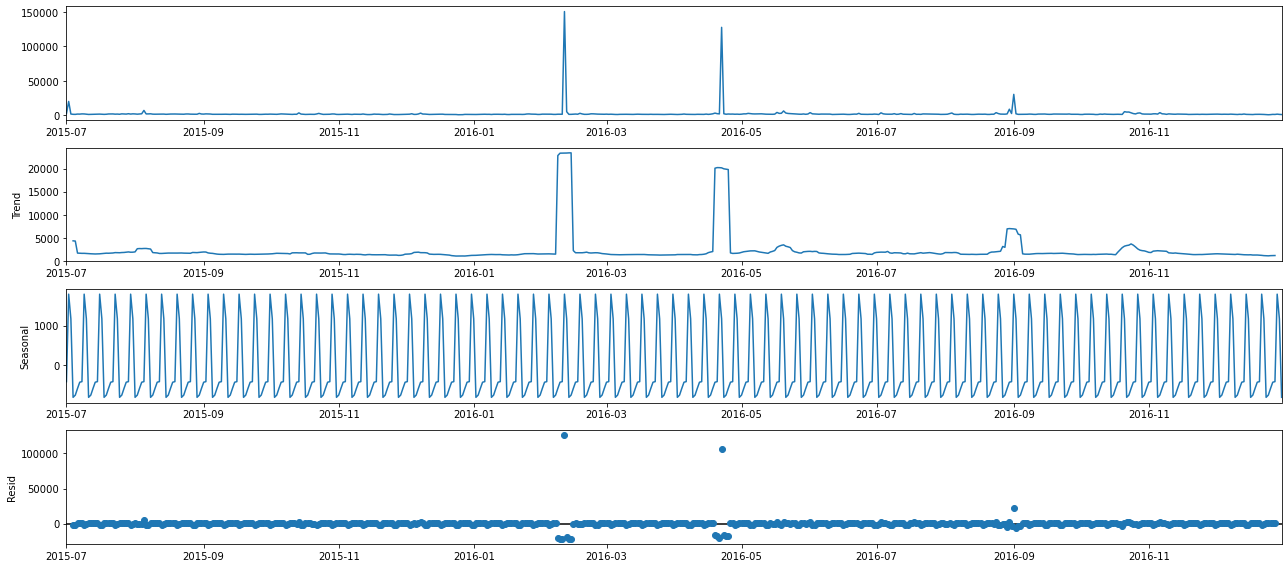

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [50]:
decompose_ts(train1_df_en_topic_melt, 'desktop_"Weird_Al"_Yankovic')

### Auto-Correlation
1. **Difference between ACF & PACF**
***

|ACF Function|PACF Function|
| --- | --- |
|Correlation between the observation at the <b>current time spot</b> and the observations at <b>previous time spots</b>|Correlation between observations at 2 time spots given that we consider <b>both observations are correlated to observations at other time spots</b>|
|   |For example, PACF of yesterday is the `real` correlation betweeen today and yesterday after taking out the influence of the day before yesterday|


2. **Auto-correlation**
***

- Let ***y*** be a repeatable process, and ***i*** be some point in time after the start of the process
- To determine: $Correlation (y_t, y_{t-s} | y_{t-s+1}, y_{t-s+2}...)$, supposed that defined values of mean, $u_i$ and variance, $\sigma_i^2$ for all time ***i***,
$$ R(s,t) = E[(X_t-u_t)(X_s-u_s)] / \sigma^2)$$, where $E$ is the expected value operator `(Pearson Correlation)`
- If the autocorrelation function is well-defined, its value must lie in the range [-1,1], with 1 indicating perfect correlation & -1 indicating perfect anti-correlation


3. **Partial auto-correlation**
***

- Partial autocorrelation of lag $k$ is the autocorrelation of $y_t$ and $y_{t+k}$ with linear dependence of $y_{t+1}$, ..., $y_{t+k-1}$ removed
- Measureing the direct effect of some period ago $y_{t+k}$ to $y_t$

Maximum p value would be 2, as Lag 2 turns out to be significant as well (manage to above the significance limit)


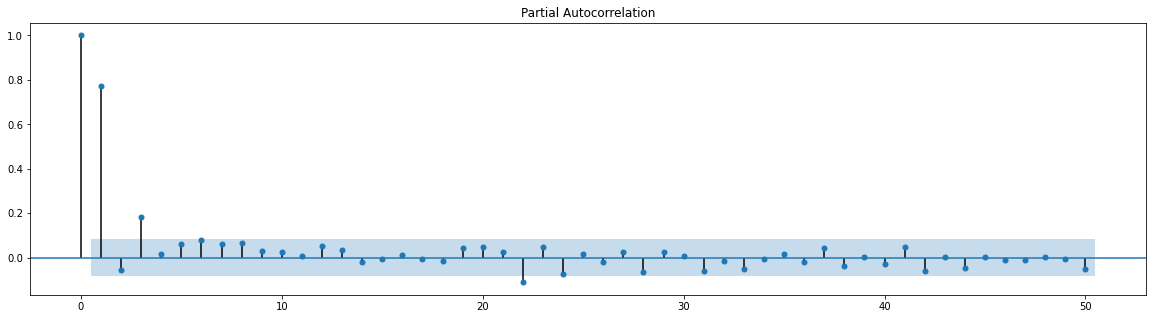

In [51]:
## Determining the p value
fig, ax = plt.subplots(figsize=(20, 5))
fig = sm.graphics.tsa.plot_pacf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], lags=50, ax=ax)

print("Maximum p value would be 2, as Lag 2 turns out to be significant as well (manage to above the significance limit)")

Maximum q value would be 21, as Lag 21 still above the significance limit


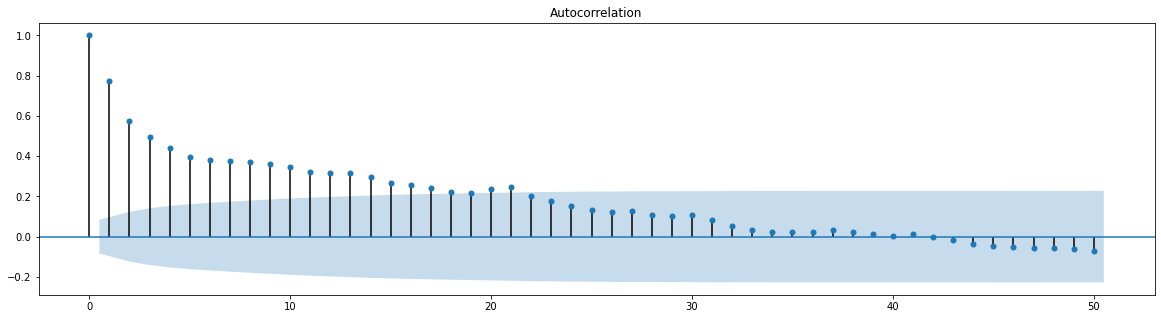

In [52]:
## Determining the q value
fig, ax = plt.subplots(figsize=(20, 5))
fig = sm.graphics.tsa.plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], lags=50, ax=ax)

print("Maximum q value would be 21, as Lag 21 still above the significance limit")

## Smoothing of Time Series
<br> 1. Simple Exponential Smoothing
***
- For series with no trend or seasonality
- Assumption: Series has only **level ($L_t$)**, 
- Estimating the **Level(L)**: $F_{t+k} = L_t$, $k$ is the steps ahead of forecast
- `The Level Updating Equation (algorithm learning new level from new data)`
$$L_t = \alpha Y_t + (1-\alpha) L_{t-1}$$, where $\alpha$  = _smoothing constant_, with 0 <= $\alpha$ <= 1
- Understanding why is it called **"Exponential Smoothing"**:
    - Weights `decrease` exponentially into the past
    - Substitute $L_t$ with its own formula
    $$L_t = \alpha Y_t + (1-\alpha)[\alpha Y_{t-1} + (1-\alpha) L_{t-2}]=$$
    $$ = \alpha Y_t + \alpha(1-\alpha) Y_{t-1} + (1-\alpha)^2 L_{t-2} = ...$$
    $$ = \alpha Y_t + \alpha(1-\alpha) Y_{t-1} + \alpha(1-\alpha)^2 Y_{t-2} + ...$$
    - Weights decrease exponentially across time
- Determine how much weight is given to the past
    - $\alpha = 1$: past values have no influence over forecasts ***(under-smoothing)***
    - $\alpha = 0$: past values have equal influene on forecasts ***(over-smoothing)***

In [ ]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 5))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [ ]:
plotExponentialSmoothing(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], [0.1, 0.3])

In [ ]:
sub_aa_train1_es_df['all_access_2012_Benghazi_attack_SES'] = exponential_smoothing(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], 0.1)

In [ ]:
sub_aa_train1_es_df

2. Holt's Exponential Smoothing
***
- For series with trend, no seasonality
- Assumption: Series has only **level ($L_t$) and trend($T_t$)**, 
- Estimating the **Level(L) + Trend (T)**:  $F_{t+k} = L_t + kT_t$, $k$ is the steps ahead of forecast
- `The Level Updating Equation (now with one more component, trend)`
$$L_t = \alpha Y_t + (1-\alpha) (L_{t-1} + T_{t-1})$$, where $\alpha$  = _smoothing constant_, with 0 <= $\alpha$ <= 1
- `The Trend Updating Equation`
$$T_t = \beta (L_t - L_{t-1}) + (1-\beta) T_{t-1}$$, update previous trend by using most recent level values
, $\beta$ controls the speed of adjusting the trend

3. Winter's Exponential Smoothing
***
- For series with both trend and seasonality

## Stationarity of a Time Series
1. A time series can be assumed to be constant if it has constant statistical properties over time, as following:
***
- Constant mean
- Constant variance
- Autocovariance that does not depend on time

<br>

2. Forecasting a stationary series is relatively easy and the forecasts are more reliable.
***

- `Autoregressive forecasting models` are essentially linear regression models that utilize the lag(s) of the series itself as predictors
   
<br>

3. Method in checking stationarity
***
- ***Rolling statistics of time series***
- ***Augmented Dickey Fuller test (ADF test)***
- ***Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary) (do not cover)*** 

<br>

### Rolling Statistics of Time Series
1. Plot the `rolling mean` and `standard deviation`
2. The time series is ***stationary*** if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis)

In [ ]:
sub_aa_train1_es_df['ROLLING_12'] = sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].rolling(window=12).mean()
sub_aa_train1_es_df['STD'] = sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].std()

In [ ]:
plt.plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], color = 'blue', label = 'Original')
plt.plot(sub_aa_train1_es_df['ROLLING_12'], color = 'red', label = 'Rolling Mean')
plt.plot(sub_aa_train1_es_df['ROLLING_12'] , color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

### Dickey Fuller Test (Unit-Root Test)

1. Dickey Fuller is conducted by calculating the difference between series:
***
$$y_i - y_{i-1} = \theta y_{i-1} + \epsilon_i - y_{i-1}$$
$$y_i - y_{i-1} = (\theta - 1)y_{i-1} + \epsilon_i$$
$$\Delta y_i = \beta y_{i-1} + \epsilon_i$$, a linear regression (OLS) equation

2. Objective:
***
   - To make sure the $\theta != 1$
   - There are 3 versions of Dickey Fuller Test:
   
|Type &nbsp; |Condition &nbsp; &nbsp; &nbsp;|Equation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
| ---- | ------------------- | ----------------------------------------------------------- |
|Type 0|No constant, no trend|$\Delta y_i = \beta_i y_{i-1} + \epsilon_i$|
|Type 1|Constant, no trend|$\Delta y_i = \beta_0 + \beta_i y_{i-1} + \epsilon_i$|
|Type 2|Constant and trend|$\Delta y_i = \beta_0 + \beta_i y_{i-1} + \beta_2 i + \epsilon_i$|
    
![image.png](images/adf_table_critical_values.png)
    
   - With the OLS equation, we can find the estimator of $\theta$ using the tau-statistics (as $\theta$ does not follow a normal distribution
   - Estimating the $\theta$ like how OLS estimating the coefficient in t-statistics:
$$t_{\theta-1} = \theta - \theta_0 / s.e(\theta)  = \theta - 1 / s.e(\theta)$$ 

5. Hypothesis Testing:
***

|Test|Implication|
| -- | --------- |
|Null Hypothesis; p-value > 0.05|$\theta = 1$, the time series is not stationary as it has `unit root`|
|Alternate Hypothesis; p-value <= 0.05|$\theta < 1$, the time series is stationary as it has no `unit root`|

<br>

****sources (Dickey Fuller): http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/****
<br>
****source (t-statistics for OLS): https://www.youtube.com/watch?v=7MAuojBTF-g****

In [ ]:
## Perform Dickey-Fuller test

def adf_test(timeseries):

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % dftest[0])
    print('p-value: %f' % dftest[1])
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if (dftest[1] > 0.05):
        print('Time Series is not stationary')
    else:
        print('Time Series is stationary')

In [ ]:
adf_test(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'])

### KPSS Test

In [ ]:
## Perform KPSS test

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpssresult = kpss(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].values)
    print('KPSS Statistic: %f' % kpssresult[0])
    print('p-value: %f' % kpssresult[1])
    print('Critical Values:')
    for key, value in kpssresult[3].items():
        print('\t%s: %.3f' % (key, value))
    
    if (kpssresult[1] > 0.05):
        print('Time Series is trend stationary')
    else:
        print('Time Series is not trend stationary')

In [ ]:
kpss_test(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'])

### Making Time Series Stationary
1. Type of stationarity
***

|Type|Description|
| -- | --------- |
|Strict Stationary|- A strict stationary series satisfies the ***mathematical definition*** of a stationary process. <br> <br> - In a strict stationary series, the ***mean, variance and covariance*** are not the function of time. <br> <br> - The aim is to convert a `non-stationary` series into a `strict stationary` series for making predictions.|
|Trend Stationary|- A series that has ***no unit root*** but exhibits a ***trend*** is referred to as a trend stationary series. <br> <br> - Once the trend is removed, the resulting series will be `strict stationary`. <br> <br> - `KPSS test` classifies a series as stationary on the absence of ***unit root*** (mean the series can be strict stationary or trend stationary|.
|Difference Stationary|- A time series that can be made `strict stationary` by differencing falls under difference stationary. <br> <br> - `ADF test` is also known as a difference stationarity test.|

<br>

2. Stationarity testing with different cases: (Both mean ADF & KPSS)
***

- **Case 1**: Both tests conclude that the series is not stationary -> `series is not stationary`
- **Case 2**: Both tests conclude that the series is stationary -> `series is stationary`
- **Case 3**: KPSS = stationary and ADF = not stationary  -> `trend stationary, remove the trend to make series strict stationary`
- **Case 4**: KPSS = not stationary and ADF = stationary -> `difference stationary, use differencing to make series stationary`

4. Detrend the time series
***

|Method|Descriptions|
| ---- | ---------- |
|**Line of Best Fit**|- Subtract the line of best fit (line of best fit can obtained from OLS model with time steps as predictor) <br> - With more complex trend, you may want to use quadratic terms (x^2)|
|**Trend Component**|- Obtained the trend component from time series decomposition <br> - Subtract original from it|

In [ ]:
## Differencing

sub_aa_train1_es_df['all_access_2012_Benghazi_attack_diff'] = sub_aa_train1_es_df['all_access_2012_Benghazi_attack'] - sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].shift(1)

sub_aa_train1_es_df['all_access_2012_Benghazi_attack_diff'].plot()

In [ ]:
## Detrending
from statsmodels.tsa.seasonal import seasonal_decompose

plt.plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], color = 'blue', label = 'Original')

## Using statmodels: Subtracting the Trend Component.
ts_components = seasonal_decompose(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], model='addictive', extrapolate_trend='freq')
detrend_result = sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].values - ts_components.trend

plt.plot(detrend_result, color = 'red', label = 'Detrend')
plt.title('Benghazi Attack detrended by subtracting the Trend component', fontsize=16)
plt.legend(loc = 'best')

plt.show()

# ARIMA Model

## ARIMA Model
1. Acronym:

|Standard|Meaning|
| ------ | ----- |
|AR: Autoregression|A model that uses the dependent relationship between an observation and some number of lagges observations|
|I: Integrated| Differencing|
|MA: Moving Average|A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations|

<br> 2. Each of these components are explicitly specified in the model as a parameter - $p, d, q$
    - p : The number of lag observations included in the model, also called the lag order.
    - d: The number of times that the raw observations are differenced, also called the degree of differencing. 
        
|Example|Equation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| ----- | ------ |
|d = 0  | $y_t = y_t$  |
|d = 1  | $y_t - y_{t-1}$  |
|d = 2  | $(y_t - y_{t-1})$ $-$ $(y_{t-1} - y_{t-2})$ = $y_t - 2y_{t-1} + y_{t-2}$  |
        
    - q: The size of the moving average window, also called the order of moving average.
    
<br> 3. Intergrate between autoregressive and moving average model:

$$y_t = c + \beta_1 y_{t-1}^" + \beta_2 y_{t-2} + .. + \beta_p y_{t-2p} \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + .. + \phi_q \epsilon_{t-q}$$ 

- **Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)**


## AR & MA Models 
1. Autoregression model **[AR(p) model]**:
    - Forecast the variable of interest using a linear combination of past values of the variables. Autoregressive model of order $p$ that depended on the `its own lag` can be written as:
$$y_t = c + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + \epsilon_t$$, where $\epsilon_t$ is white noise, lagged values of $y_t$ as predictors, $\beta$ is the coefficient of lag 1 that the model estimates, $c$ is the coefficient

<br> 2. Moving Average Model **[MA(q) model]**:
- Forecast the variable where $y_t$ depended only on the `lagged forecast errors` $$y_t = c + \epsilon + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_p \epsilon_{t-p}$$, where the error terms are the errors of the autoregressive models of the respective lags
- The error term $\epsilon_t$ and $\epsilon_{t-1}$ are the errors of the following equations:
$$y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_0 y_0 + \epsilon_t$$
$$y_{t-1} = \beta_1 y_{t-2} + \beta_2 y_{t-3} + ... + \beta_0 y_0 + \epsilon_{t-1}$$

## Before moving to model, 
- Value of p
- Value of d
- Value of q

### Value of P

In [ ]:
def scatter_lag_plots(df, no_of_lags, col, title):
    fig, axes = plt.subplots(1, 4, figsize=(15,4), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:no_of_lags]):
        lag_plot(df[col], lag=i+1, ax=ax, c='red')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle(title, weight='bold')    
    plt.show()
    
    return plt

In [ ]:
scatter_lag_plots(sub_aa_train1_es_df, 4, 'all_access_2012_Benghazi_attack', 'Lag Plots of Benghazi Attack 2012')

In [ ]:
## Determining the p value
fig, ax = plt.subplots(figsize=(20,5))
fig = sm.graphics.tsa.plot_pacf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], lags=50, ax=ax)

print("Maximum p value would be 2, as Lag 2 turns out to be significant as well (manage to above the significance limit)")

### Value of d
1. Right order of differencing: 
    - Minimum differencing that will get a near-stationary series which roams around a defined mean
    - ACF plot reaches to zero fairly quick

In [ ]:
# Original Series
fig, axes = plt.subplots(5, 2)

axes[0, 0].plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack']); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'], lags=50, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=2)); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=2).dropna(), ax=axes[2, 1])

# 2nd Differencing
axes[3, 0].plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=3)); axes[3, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=3).dropna(), ax=axes[3, 1])

# 3rd Differencing
axes[4, 0].plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=4)); axes[4, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=4).dropna(), ax=axes[4, 1])

plt.subplots_adjust(hspace=0.9, wspace=0.15)

plt.show()

1st order differencing reach negative too quickly, which may indicicate over-differencing and its not good

### Value of q
- The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=2)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))

plot_acf(sub_aa_train1_es_df['all_access_2012_Benghazi_attack'].diff(periods=2).dropna(), ax=axes[1])

plt.show()

## Forecast Model

In [ ]:
def arima_residual_plot(ar_model, col):
    residuals = pd.DataFrame(ar_model.resid)

    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    # Actual vs Predicted
    fig, ax = plt.subplots(figsize=(20,5))
    fig = ar_model.plot_predict(dynamic=False, ax=ax)
    plt.title('Actual vs Predicted of {}'.format(col), fontsize=18, weight='bold')
    plt.xlabel('Date'.format(col), fontsize=15)
    plt.ylabel('Values'.format(col), fontsize=15)
    
    return

In [ ]:
def arima_model_plot(p, d, q, x, test_size):
    model = ARIMA(x, order=(p,d,q))

    arima_model = model.fit(disp=1)

    fc, se, conf = arima_model.forecast(test_size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=y.index)
    lower_series = pd.Series(conf[:, 0], index=y.index)
    upper_series = pd.Series(conf[:, 1], index=y.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(x, label='training')
    plt.plot(y, label='actual')
    plt.plot(fc_series, label='forecast', color='red')

    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
     
    return fc, se, conf

In [ ]:
sub_aa_train1_es_model_df = sub_aa_train1_es_df[['all_access_2012_Benghazi_attack']]

In [ ]:
## Testing with order on lag value 5, difference order 1, moving average model 0
model = ARIMA(sub_aa_train1_es_model_df, order=(2,0,2))

arima_model = model.fit(disp=0)
arima_model.summary()

Understanding Model Results:
1. **AIC (Akaike Information Criterion)**: 
    - Testing on how well the models fit the data without overfitting it
    - However, AIC is not so much use unless you compared with AIC of other model
    - Model with low AIC, is expected to strike a superior balance between the ability to fit the data set and its ability to avoid over-fitting the data set
    - Formula: $AIC = 2k - 2ln(l)$, where $k$ = number of model parameters, $l$ = log likelihood function of the model
    - $l$ is the log likelihood function, which is $e^k/L$, where $k$ = number of model parameters, $L$ maximum likelihood$

2. **BIC (Bayesian Information Criterion)**: 
    - Formula: $BIC = ln(n)k - 2ln(L)$, where $L$ = maximized value of likelihood function of the model, $n$ = number of data points, $k$ = number of free parameters to be estimated

In [ ]:
arima_residual_plot(arima_model, 'all_access_2012_Benghazi_attack')

In [ ]:
## Splitting and run model

x, y = sub_aa_train1_es_model_df[0: int(len(sub_aa_train1_es_model_df) * 0.75)], sub_aa_train1_es_model_df[int(len(sub_aa_train1_es_model_df) * 0.75):]
print('Training Dataset: %d, Testing Dataset: %d' % (len(x), len(y)))

In [ ]:
fc, se, conf = arima_model_plot(2, 1, 1, x, 138)

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape, 'mae': mae, 
            'rmse':rmse})

forecast_accuracy(fc, y.values)

**Types of ARIMA Models:**
<br> 1. ARIMA(1,0,0) = first-order autoregressive model
    - if the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant

<br> 2. ARIMA(0,1,0) = random walk
    - If the series Y is not stationary, the simplest possible model for it is a random walk model, which can be considered as a limiting case of an AR(1) model in which the autoregressive coefficient is equal to 1
   
<br> 3. ARIMA(1,1,0) = differenced first-order autoregressive model
    - If the errors of a random walk model are autocorrelated, perhaps the problem can be fixed by adding one lag of the dependent variable to the prediction equation
    
<br> 4. ARIMA(0,1,1) without constant = simple exponential smoothing
    - For correcting autocorrelated errors in a random walk model is suggested by the simple exponential smoothing model

### Auto ARIMA model forecast

In [ ]:
model = pm.auto_arima(sub_aa_train1_es_model_df['all_access_2012_Benghazi_attack'], start_p=1, d=0, start_q=1,
                      test='adf',                  # use adftest to find optimal 'd'
                      max_p=3, max_d=3, max_q=3,   # maximum p, d, q
                      m=1,                         # frequency of series
                      seasonal=False,              # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

In [ ]:
print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(12,12))
plt.show()

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.

In [ ]:
sub_aa_train1_es_model_df.reset_index(inplace=True)

In [ ]:
# Forecast
n_periods = 100
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(sub_aa_train1_es_model_df['all_access_2012_Benghazi_attack']), len(sub_aa_train1_es_model_df['all_access_2012_Benghazi_attack'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(sub_aa_train1_es_model_df['all_access_2012_Benghazi_attack'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### Prophet

In [ ]:
import fbprophet